In [279]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from flares.flares import create_flare_light_curve, flare_contrast
from fleck import generate_spots, Star
import astropy.units as unit

import matplotlib.patches as mpatches

In [222]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import art3d
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import Circle

def rotation_matrix(v1,v2):
    """
    Calculates the rotation matrix that changes v1 into v2.
    """
    v1/=np.linalg.norm(v1)
    v2/=np.linalg.norm(v2)

    cos_angle=np.dot(v1,v2)
    d=np.cross(v1,v2)
    sin_angle=np.linalg.norm(d)

    if sin_angle == 0:
        M = np.identity(3) if cos_angle>0. else -np.identity(3)
    else:
        d/=sin_angle

        eye = np.eye(3)
        ddt = np.outer(d, d)
        skew = np.array([[    0,  d[2],  -d[1]],
                      [-d[2],     0,  d[0]],
                      [d[1], -d[0],    0]], dtype=np.float64)

        M = ddt + cos_angle * (eye - ddt) + sin_angle * skew

    return M

def pathpatch_2d_to_3d(pathpatch, z = 0, normal = 'z'):
    """
    Transforms a 2D Patch to a 3D patch using the given normal vector.

    The patch is projected into they XY plane, rotated about the origin
    and finally translated by z.
    """
    if type(normal) is str: #Translate strings to normal vectors
        index = "xyz".index(normal)
        normal = np.roll((1,0,0), index)

    path = pathpatch.get_path() #Get the path and the associated transform
    trans = pathpatch.get_patch_transform()

    path = trans.transform_path(path) #Apply the transform

    pathpatch.__class__ = art3d.PathPatch3D #Change the class
    pathpatch._code3d = path.codes #Copy the codes
    pathpatch._facecolor3d = pathpatch.get_facecolor #Get the face color    

    verts = path.vertices #Get the vertices in 2D

    M = rotation_matrix(normal,(0, 0, 1)) #Get the rotation matrix

    pathpatch._segment3d = np.array([np.dot(M, (x, y, 0)) + (0, 0, z) for x, y in verts])

def pathpatch_translate(pathpatch, delta):
    """
    Translates the 3D pathpatch by the amount delta.
    """
    pathpatch._segment3d += delta


ValueError: Argument Z must be 2-dimensional.

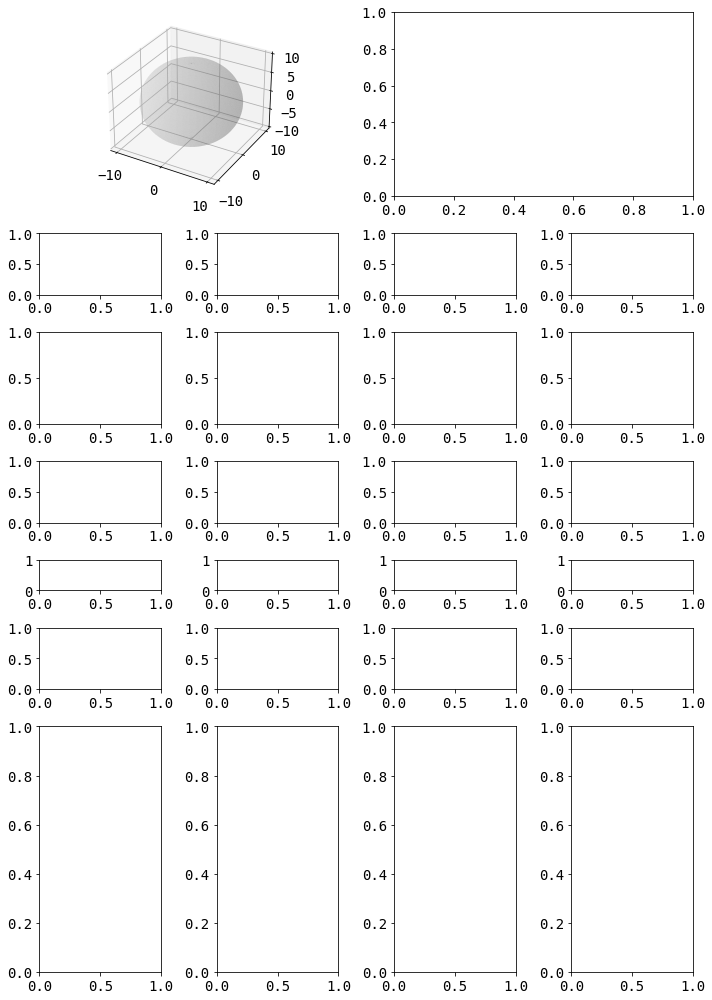

In [411]:
%matplotlib inline
fig, axs = plt.subplots(nrows=7, ncols=4, figsize=(10,14), gridspec_kw={'width_ratios': [1,1,1,1],
                                                                      'height_ratios': [3,1,1.5, 1,0.5,1,4]})

gs = axs[0, 1].get_gridspec()
# remove the underlying axes
for ax in axs[0, :2]:
    ax.remove()
    
axlefttop = fig.add_subplot(gs[0, :2], projection="3d")

gs = axs[0, 2].get_gridspec()
# remove the underlying axes
for ax in axs[0, 2:]:
    ax.remove()
    
axleftbottom = fig.add_subplot(gs[0, 2:], )

# LEFT PANEL



# TOP:
# plot sphere


# Make data
r = 10
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = r * np.outer(np.cos(u), np.sin(v))
y = r * np.outer(np.sin(u), np.sin(v))
z = r * np.outer(np.ones(np.size(u)), np.cos(v))

# Plot the surface
axlefttop.plot_surface(x, y, z, color='silver',zorder=-10, alpha=.2)

axlefttop.plot_surface(x[z>5], y[z>5], z[z>5], color='red',zorder=-10, alpha=.2)

# plot foreshortened circle

for phi_ in [-.1,-.2,.2]:
    theta, phi = .25*np.pi+np.random.normal(0,.01), phi_*np.pi
    x_spot, y_spot, z_spot, r_spot = (r * np.cos(phi) * np.sin(theta),
                                      r * np.sin(phi)*np.sin(theta),
                                      r * np.cos(theta),
                                      .3)  

    # axlefttop.scatter([0,x_spot,x_spot], [0,y_spot,y_spot], [z_spot,z_spot,0],
    #                   zorder=30, s=100, c="green")
    p = Circle((x_spot, y_spot), r_spot, facecolor="k",zorder=20)
    axlefttop.add_patch(p)

    pathpatch_2d_to_3d(p, z=z_spot, normal=(x_spot,y_spot,z_spot))
    loca = -p._segment3d.mean(axis=0)+(x_spot,y_spot,z_spot)
    pathpatch_translate(p, loca)
axlefttop.text(loca[0], loca[1], loca[2]+1., s="flaring region", fontsize=12)

# plot rotation axis
axlefttop.plot([0,0], [0,0], [r,r+2.5],
                  zorder=30, c="k")
axlefttop.text(0, 1, r+1., s="rotation axis", fontsize=12)

# plot equator
u = np.linspace(-np.pi/2, np.pi/2, 100)
axlefttop.plot(r * np.cos(u),
               r * np.sin(u),
               [0]*len(x), c="k",linestyle="dotted",
              zorder=20)

# layout
axlefttop.view_init(35, 0)
axlefttop.set_xlim(-7,7)
axlefttop.set_ylim(-7,7)
axlefttop.set_zlim(-5.4,5.4)
axlefttop.set_axis_off()
axlefttop.set_title(r"flaring star")

# BOTTOM
# plot intrinsic flare light curve
# plot modulated flare light curve
time = np.linspace(0, 2*np.pi, 2000)
flares=flare_contrast(time, 1, [1], [1e6], -2, 30,1)
axleftbottom.plot(time/np.pi/2,flares[:,0,0],c="grey",label="intrinsic")

# quadratic limd darkening
u_ld = [0.5079, 0.2239]
lons, lats, radii, inc_stellar = generate_spots(theta-0.1 ,
                                                theta+1 ,
                                                r_spot, 1,
                                                n_inclinations=5)
# make star! 
star = Star(spot_contrast=flares, phases=time * unit.rad, u_ld=u_ld)
lcs = star.light_curve(lons, lats, radii, inc_stellar)

axleftbottom.plot(time/np.pi/2,(lcs[:,0]-1.)*8.5+1,c="green",label="observed")
axleftbottom.set_xlim(0,1)
axleftbottom.set_xlabel("rotational phase")
axleftbottom.set_ylabel("flux")
axleftbottom.get_yaxis().set_ticks([])
axleftbottom.spines['top'].set_visible(False)
axleftbottom.spines['right'].set_visible(False)
axleftbottom.legend(frameon=False,loc=0)
# layout

axleftbottom.set_title(r"observed light curve")

# plot text "generate stars"
gs = axs[1, 0].get_gridspec()
# remove the underlying axes
for ax in axs[1, :]:
    ax.remove()
    
ax = fig.add_subplot(gs[1, :])
x_tail = 0.2
y_tail = 1.
x_head = 0.2
y_head = 0.0
dx = x_head - x_tail
dy = y_head - y_tail

arrow = mpatches.FancyArrowPatch((x_tail, y_tail), (x_head, y_head), mutation_scale=50)
ax.add_patch(arrow)

ax.text(x=0.3,y=0.,s="generate light curves of stars with\ndifferent active latitude properties,\nviewed at different inclinations",fontsize=14)
ax.set_axis_off()

# plot 4 instrinsic light curves
for col in [0,1,3]:
    ax = axs[2,col]
    ax.plot(time/np.pi/2,lcs[:,col],c="green")
    ax.set_xlim(0,1)
    ax.set_xlabel("phase",fontsize=10)
    ax.set_ylabel("flux",fontsize=10)
    ax.get_yaxis().set_ticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
ax = axs[2,2]
ax.set_axis_off()
ax.text(x=0.,y=0.5, s="...",fontsize=25,transform=ax.transAxes)


# plot arrow down with "find and characterize flares"
gs = axs[3, 1].get_gridspec()
# remove the underlying axes
for ax in axs[3, :]:
    ax.remove()
    
ax = fig.add_subplot(gs[3, :])
x_tail = 0.2
y_tail = 1.
x_head = 0.2
y_head = 0.0
dx = x_head - x_tail
dy = y_head - y_tail

arrow = mpatches.FancyArrowPatch((x_tail, y_tail), (x_head, y_head), mutation_scale=50)
ax.add_patch(arrow)

ax.text(x=0.3,y=0.,s="find and characterize flares\nin each light curve",fontsize=14)
ax.set_axis_off()
# ax.set_xlim(0.4,0.6)
# make flare table mock-up
for col in [0,1,3]:
    ax = axs[4][col]
    the_table = ax.table(cellText=['...','...','...'],
                          rowLabels=["flare #1","#2","#3"],

                          colLabels=["tstart","ED", "a","1"],
                          loc='center',fontsize=12)
    ax.set_axis_off()
    
ax = axs[4,2]
ax.set_axis_off()
ax.text(x=0.,y=0., s="...",fontsize=25,transform=ax.transAxes)
# plot flare table mock-up
# plot curvy bracket down


# plot text "groupby active latitude properties, e.g., mid-latitude"
gs = axs[5, 0].get_gridspec()
# remove the underlying axes
for ax in axs[5, :]:
    ax.remove()
    
ax = fig.add_subplot(gs[5, :])
x_tail = 0.2
y_tail = 1.
x_head = 0.2
y_head = 0.0
dx = x_head - x_tail
dy = y_head - y_tail

arrow = mpatches.FancyArrowPatch((x_tail, y_tail), (x_head, y_head), mutation_scale=50)
ax.add_patch(arrow)

ax.text(x=0.3,y=0.,s="group tables by active latitude\nproperties and calculate summary\nstatistic",fontsize=14)
ax.set_axis_off()

# plot arrow down with "compute summary statistic"
# plot active latitude property vs summary statistic
gs = axs[6, 0].get_gridspec()
# remove the underlying axes
for ax in axs[6, 1:3]:
    ax.remove()
    
ax = fig.add_subplot(gs[6, 1:3])
x = np.linspace(0,1,100)
ax.scatter(x,np.random.normal(0,.3,100)+x**2*3)
ax.set_xlabel("active latitude property")
ax.set_ylabel("summary statistic")

axs[6][0].set_axis_off()
axs[6][3].set_axis_off()

plt.tight_layout()




Model illustration: Stellar ensembles with flaring active latitudes. Read top to bottom, then left to right.

Top left panel: stellar sphere with a single active region placed within an active latitude strip. 

Bottom left panel, in grey: Light curve of that star through a full rotation, assuming sources of variability except for flares are removed, as seen from above the active region. 

Bottom-left panel, in black: Same light curve but as measured from the reader's point of view, accounting for geometric foreshortening and visibility. 

Top right panel: Ensemble of stars with varying ancillary properties, stellar inclinations and active latitude properties.

Mid-right panel: Sets of flares detected in each light curve are grouped into ensembles by active latitude properties of their stars. Summary statistics are computed for flaring properties for each ensemble.

Bottom-right panel: Model output, i.e. the relation between a summary statistic, and the active latitude property.



In [184]:
np.linalg.norm((x_spot,y_spot,z_spot))

10.0